In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
sns.set_style(style="white")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

import utils
import constants

In [2]:
def drop_and_fill(data):
    data["timestamp"] = pd.to_datetime(data["timestamp"])
    data = data.drop(["QGL", "T-JUS-CKGL", "P-JUS-CKGL"], axis=1)
    data = data.fillna(0)
    data = data.set_index("timestamp")
    
    return data

### Plot single instances

In [3]:
data = pd.read_csv("D:/Projects/3W/dataset/0/WELL-00005_20170815200000.csv")
data = data.set_index("timestamp")[["P-PDG", "P-TPT", "T-TPT", "P-MON-CKP", "T-JUS-CKP", "class"]]
data = data.sort_index()
data = data.reset_index(drop=True)

In [4]:
def plot_sensor(sensor, unit, axis, index):
    i, j = index
    axis[i][j].plot(data[data["class"] == 0][sensor], color="green", label="Normal")
    axis[i][j].plot(data[data["class"] != 0][sensor], color="red", label="Anomalia")
    axis[i][j].set_title(sensor)
    axis[i][j].set_ylabel(unit)

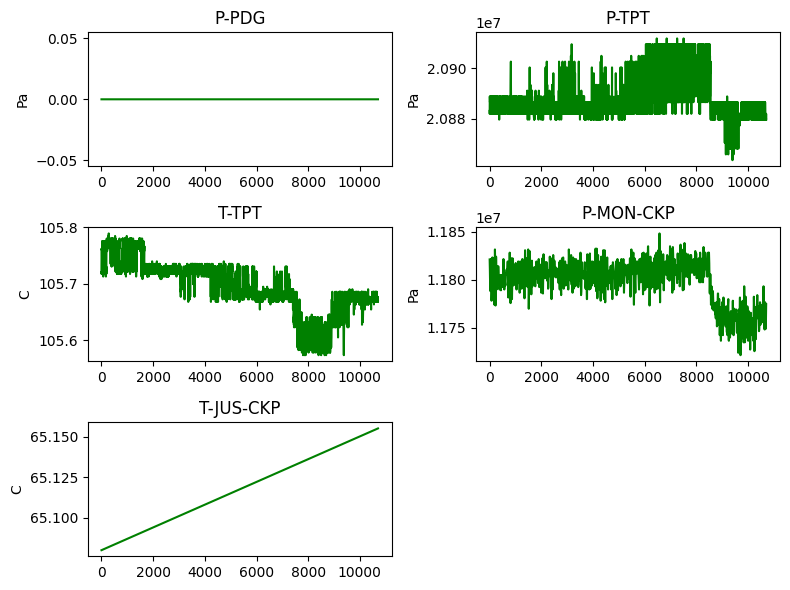

In [5]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(8, 6))

plot_sensor("P-PDG", unit="Pa", axis=ax, index=[0,0])
plot_sensor("P-TPT", unit="Pa", axis=ax, index=[0,1])
plot_sensor("T-TPT", unit="C", axis=ax, index=[1,0])
plot_sensor("P-MON-CKP", unit="Pa", axis=ax, index=[1,1])
plot_sensor("T-JUS-CKP", unit="C", axis=ax, index=[2,0])

f.delaxes(ax[2][1])
f.tight_layout()

### Generate training dataset

Add normal sequences

In [6]:
train_df = pd.DataFrame()
train_normal, test_normal = utils.read_files(constants.FILE_PATH, classes=[constants.NORMAL_CLASS], real_only=True, test_size=0.6)

for file in tqdm(train_normal):
    data = pd.read_csv(file)
    data = drop_and_fill(data)
    #data = data.drop("class", axis=1)
    n_sequences = len(data) // constants.STEPS
    data = data.iloc[:n_sequences*constants.STEPS]

    train_df = pd.concat([train_df, data])

100%|██████████| 239/239 [00:40<00:00,  5.96it/s]


Add normal sequences from abnormal files

In [7]:
train_abnormal, test_abnormal = utils.read_files(constants.FILE_PATH, classes=constants.ABNORMAL_CLASSES, real_only=True, test_size=0.5)

for file in tqdm(train_abnormal):
    data = pd.read_csv(file)
    data = drop_and_fill(data)

    # Get normal sequence
    data = data[data["class"] == 0]
    
    #data = data.drop("class", axis=1)
    n_sequences = len(data) // constants.STEPS
    data = data.iloc[:n_sequences*constants.STEPS]
    train_df = pd.concat([train_df, data])

100%|██████████| 213/213 [00:36<00:00,  5.89it/s]


In [9]:
# Store until when there are normal samples to create y_train later
normal_samples = len(train_df) / constants.STEPS

Add anomaly sequences

In [10]:
for file in tqdm(train_abnormal):
    data = pd.read_csv(file)
    data = drop_and_fill(data)

    # Get abnormal sequence
    data = data[data["class"].isin(constants.ABNORMAL_CLASSES)]
    
    #data = data.drop("class", axis=1)
    n_sequences = len(data) // constants.STEPS
    data = data.iloc[:n_sequences*constants.STEPS]

    train_df = pd.concat([train_df, data])

100%|██████████| 213/213 [00:41<00:00,  5.09it/s]


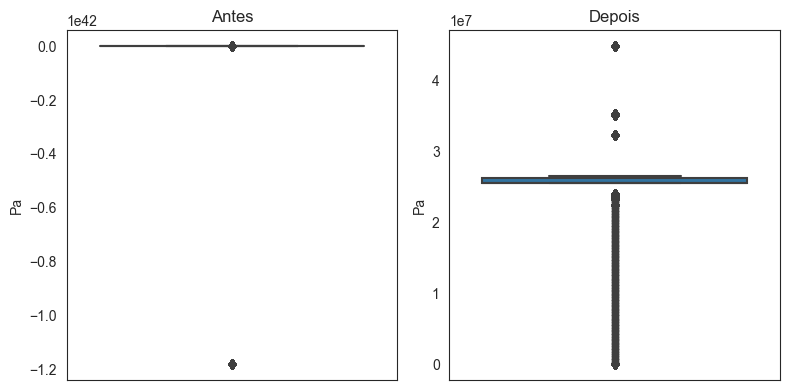

In [9]:
f, ax = plt.subplots(ncols=2, figsize=(8, 4))
sns.boxplot(data=train_df, y="P-PDG", ax=ax[0])
sns.boxplot(data=train_df[train_df["P-PDG"] > -0.5*1e42], y="P-PDG", ax=ax[1])

ax[0].set_title("Antes")
ax[1].set_title("Depois")

ax[0].set_ylabel("Pa")
ax[1].set_ylabel("Pa")

plt.tight_layout()

In [11]:
# Removing extreme outliers to improve standardization
train_df = train_df[train_df["P-PDG"] > -0.5*1e42]

In [12]:
scaler = StandardScaler()
train = scaler.fit_transform(train_df.drop("class", axis=1))

Text(0.5, 1.0, 'P-PDG')

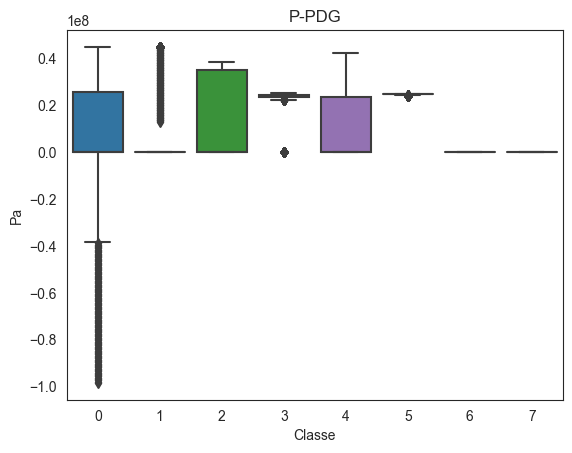

In [31]:
sns.boxplot(
    data=train_df,
    x="class",
    y="P-PDG"
)

plt.xlabel("Classe")
plt.ylabel("Pa")

plt.title("P-PDG")

Text(0.5, 1.0, 'P-TPT')

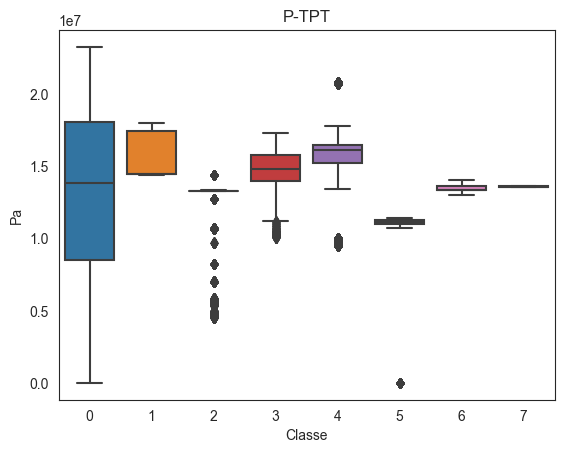

In [33]:
sns.boxplot(
    data=train_df[train_df["P-TPT"] < 1e9],
    x="class",
    y="P-TPT"
)

plt.xlabel("Classe")
plt.ylabel("Pa")

plt.title("P-TPT")

Text(0.5, 1.0, 'T-TPT')

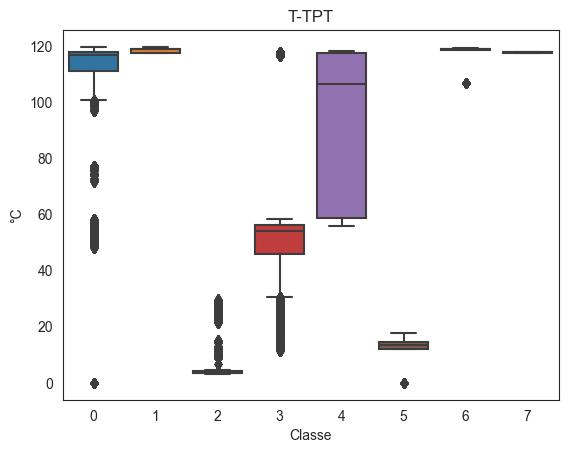

In [34]:
sns.boxplot(
    data=train_df,
    x="class",
    y="T-TPT"
)

plt.xlabel("Classe")
plt.ylabel("°C")

plt.title("T-TPT")

Text(0.5, 1.0, 'P-MON-CKP')

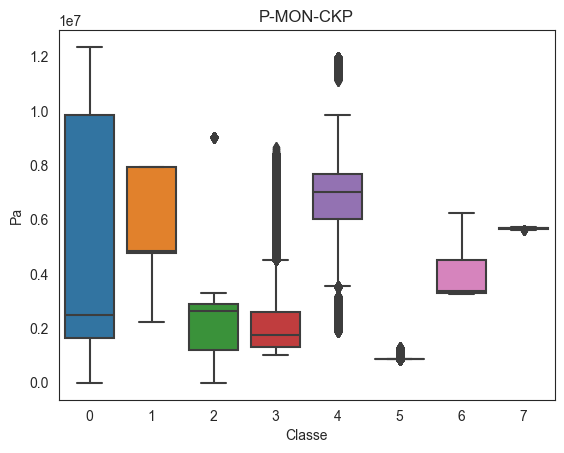

In [36]:
sns.boxplot(
    data=train_df,
    x="class",
    y="P-MON-CKP"
)

plt.xlabel("Classe")
plt.ylabel("Pa")

plt.title("P-MON-CKP")

Text(0.5, 1.0, 'T-JUS-CKP')

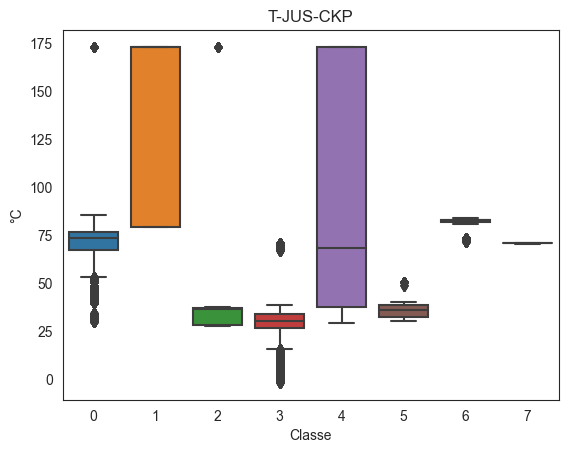

In [37]:
sns.boxplot(
    data=train_df,
    x="class",
    y="T-JUS-CKP"
)

plt.xlabel("Classe")
plt.ylabel("°C")

plt.title("T-JUS-CKP")

In [14]:
train_sequences = utils.create_sequence(train)

In [20]:
x_train = []
for seq in tqdm(train_sequences):
    features = utils.get_features(seq)
    x_train.append(features)
    
x_train = np.array(x_train).reshape(len(x_train), 15)
y_train = [0 if i < normal_samples else 1 for i in range(len(x_train))]
y_train = np.array(y_train)

100%|██████████| 89317/89317 [01:18<00:00, 1132.38it/s]


In [34]:
cols = []

for var in ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']:
    for metric in ['Mean', 'Std', 'Var', 'Min', 'Max']:
        cols.append(var + ' - ' + metric)

x_df = pd.DataFrame(x_train, columns=cols)

In [37]:
# Normal class ratio
normal_samples / len(x_train)

0.7199189404032826

In [30]:
print("k | Mean | Std")
print("--------------")

for k in range(1, 102, 20):
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    scores = []

    for train_idx, test_idx in skf.split(x_train, y_train):
        pca = PCA(n_components=0.99)
        xx_train = pca.fit_transform(x_train[train_idx])
        xx_test = pca.transform(x_train[test_idx])

        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(xx_train, y_train[train_idx])
        p = knn.predict(xx_test)
        f1_score = utils.f1(y_train[test_idx], p)
        scores.append(f1_score)

    scores = np.array(scores)
    print(f"{str(k).zfill(2)}  {scores.mean():.2f}  {scores.std():.2f}")

k | Mean | Std
--------------
01  1.00  0.00
21  1.00  0.00
41  0.99  0.00
61  0.99  0.00
81  0.99  0.00
101  0.99  0.00


In [36]:
#pca = PCA(n_components=0.99)
#pca_x_train = pca.fit_transform(x_train)

knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=21)

In [61]:
skf = StratifiedKFold(n_splits=5)
scores = []

for train_idx, test_idx in skf.split(x_train, y_train):
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(x_train[train_idx], y_train[train_idx])
    p = rf.predict(x_train[test_idx])
    f1_score = utils.f1(y_train[test_idx], p)
    scores.append(f1_score)

scores = np.array(scores)
print(f"RF: {scores.mean():.2f}  {scores.std():.2f}")

RF: 0.79  0.31


### Test single file

In [37]:
test_data = pd.read_csv(test_abnormal[3])
test_data = drop_and_fill(test_data)
test_data = test_data.drop("class", axis=1)
test_data_preprocessed = scaler.transform(test_data)

test_sequences = utils.create_sequence(test_data_preprocessed)

x_test = []

for seq in test_sequences:
    features = utils.get_features(seq)
    x_test.append(features)

x_test = np.array(x_test).reshape(len(x_test), 15)

In [38]:
#x_test = pca.transform(x_test)
preds = knn.predict(x_test)
preds = np.repeat(preds, constants.STEPS)

# Remove leftover out of sequences
test_data = test_data.iloc[:len(preds)]

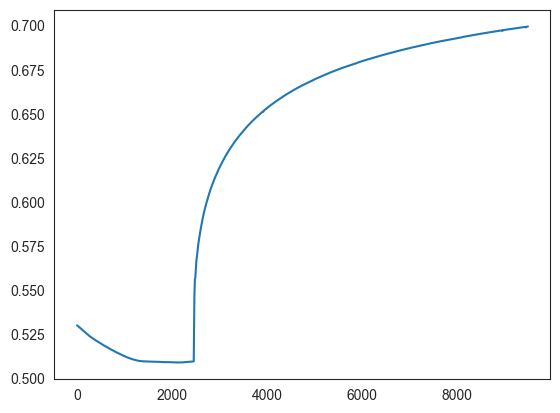

In [58]:
plt.plot(test_data_preprocessed[:, 0])

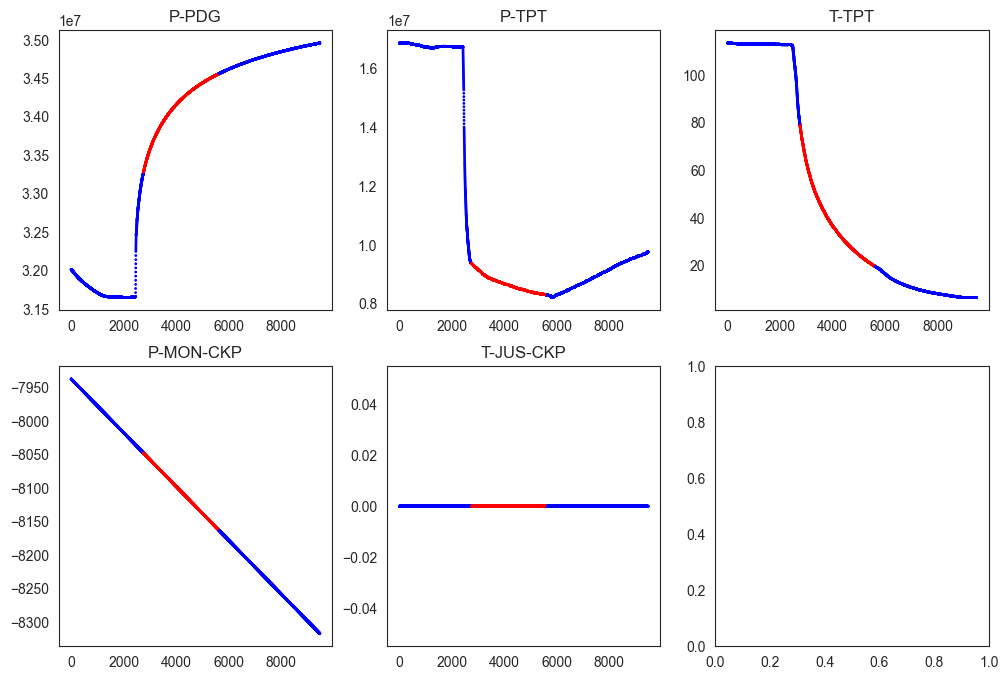

In [39]:
rows = 2
cols = 3

f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))

columns = test_data.columns

# Normal = Blue
# Anomaly = Red
colors = ["blue" if pred == 0 else "red" for pred in preds]

for i in range(rows):
    for j in range(cols):
        try:
            ax[i][j].scatter(x=range(len(test_data)), y=test_data[columns[i*(rows+1) + j]].values, c=colors, s=1)
            ax[i][j].set_title(columns[i*(rows+1) + j])
        except:
            continue

### Test all files

In [103]:
test_df = pd.DataFrame()

for file in tqdm(test_normal[:100]):
    data = pd.read_csv(file)
    data = drop_and_fill(data)
    data = data.drop("class", axis=1)
    
    n_sequences = len(data) // constants.STEPS
    data = data.iloc[:n_sequences*constants.STEPS]
    test_df = pd.concat([test_df, data])

100%|██████████| 100/100 [00:15<00:00,  6.45it/s]


In [104]:
for file in tqdm(test_abnormal):
    data = pd.read_csv(file)
    data = drop_and_fill(data)

    # Get normal sequence
    data = data[data["class"] == 0]
    
    data = data.drop("class", axis=1)
    n_sequences = len(data) // constants.STEPS
    data = data.iloc[:n_sequences*constants.STEPS]
    test_df = pd.concat([test_df, data])

100%|██████████| 212/212 [00:27<00:00,  7.79it/s]


In [105]:
normal_samples = len(test_df) / constants.STEPS

In [106]:
for file in tqdm(test_abnormal):
    data = pd.read_csv(file)
    data = drop_and_fill(data)

    # Get abnormal sequence
    data = data[data["class"] != 0]
    
    data = data.drop("class", axis=1)
    n_sequences = len(data) // constants.STEPS
    data = data.iloc[:n_sequences*constants.STEPS]
    test_df = pd.concat([test_df, data])

100%|██████████| 212/212 [00:30<00:00,  6.97it/s]


In [107]:
test_df = scaler.transform(test_df)

test_sequences = utils.create_sequence(test_df)

In [108]:
x_test = []

for seq in tqdm(test_sequences):
    features = utils.get_features(seq)
    x_test.append(features)

x_test = np.array(x_test).reshape(len(x_test), 25)

100%|██████████| 60195/60195 [00:04<00:00, 14533.08it/s]


In [109]:
y_test = [0 if i < normal_samples else 1 for i in range(len(x_test))]

In [110]:
preds = knn.predict(pca.transform(x_test))

<AxesSubplot:>

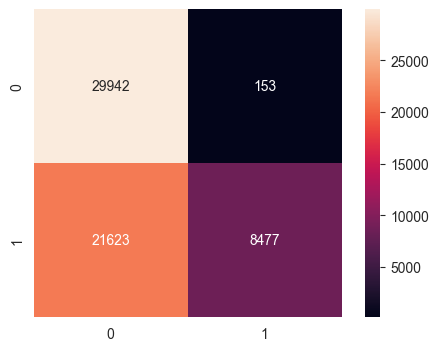

In [111]:
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", square=True)

In [112]:
utils.f1(y_test, preds)

0.4377485153627679